In [691]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim

In [692]:
DF_cleaned=pd.read_csv('DF_nettoyé.csv')

In [693]:
DF_cleaned.head()

,OSEBuildingID,BuildingType,PropertyName,Address,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,...,%_elec(kBtu),%_gas(kBtu),%_steam(kBtu),%_parking,%_immeuble,PrimaryPropertyType_Autres,PrimaryPropertyType_Education et Services Communautaires,PrimaryPropertyType_Immobilier Commercial,PrimaryPropertyType_Logistique et Stockage,PrimaryPropertyType_Santé
0,1,NonResidential,Mayflower park hotel,405 Olive way,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,...,55.0,18.0,28.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0
1,2,NonResidential,Paramount Hotel,724 Pine street,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,...,39.0,61.0,0.0,15.0,85.0,0.0,0.0,1.0,0.0,0.0
2,3,NonResidential,5673-The Westin Seattle,1900 5th Avenue,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,...,68.0,2.0,30.0,21.0,79.0,0.0,0.0,1.0,0.0,0.0
3,5,NonResidential,HOTEL MAX,620 STEWART ST,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,...,41.0,27.0,33.0,0.0,100.0,0.0,0.0,1.0,0.0,0.0
4,8,NonResidential,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,...,38.0,62.0,0.0,35.0,65.0,0.0,0.0,1.0,0.0,0.0


In [694]:
DF_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1429 entries, 0 to 1428
Data columns (total 37 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   OSEBuildingID                                             1429 non-null   int64  
 1   BuildingType                                              1429 non-null   object 
 2   PropertyName                                              1429 non-null   object 
 3   Address                                                   1429 non-null   object 
 4   ZipCode                                                   1429 non-null   float64
 5   TaxParcelIdentificationNumber                             1429 non-null   object 
 6   CouncilDistrictCode                                       1429 non-null   int64  
 7   Neighborhood                                              1429 non-null   object 
 8   Latitude          

ON VA DROP UNE COLONNE DU ONE HOT POUR LA REGRESSION LINEAIRE CAR SINON VARIABLES TROP CORELLEES

In [695]:
DF_cleaned_lineaire=DF_cleaned.drop(['PrimaryPropertyType_Autres'],axis=1)

ON VA DROP TOTALGHGEMISSION CAR PAS DISPO LORS DE L'ETUDE

In [696]:
DF_cleaned_lineaire=DF_cleaned_lineaire.drop(['TotalGHGEmissions'],axis=1)

In [697]:
DF_cleaned_lineaire['BuildingType'].unique()

array(['NonResidential'], dtype=object)

In [698]:
DF_cleaned_lineaire.shape

(1429, 35)

In [699]:
col_num=[]
col_obj=[]
for col in DF_cleaned_lineaire.columns:
    if DF_cleaned_lineaire[col].dtype in ['int64','float64'] :
        col_num.append(col)
    else:
        col_obj.append(col)

In [700]:
colonne_à_retirer=[]
for col in col_num:
    if DF_cleaned_lineaire[col].isna().sum()!=0:
        colonne_à_retirer.append(col)
print(colonne_à_retirer)
for t in colonne_à_retirer:
    del(col_num[col_num.index(t)])

['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore']


# VERIFICATION DES HYPOTHESES DE LA REGRESSION LINEAIRE

## 1) ETUDE DU VIF ( Varaince Inflation Factor )

In [701]:

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

data =DF_cleaned_lineaire[col_num]
X = sm.add_constant(data)

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\n Analyse VIF (multicolinéarité)")
vif_data = calculate_vif(X.drop('const', axis=1))
print(vif_data)


 Analyse VIF (multicolinéarité)


                                             Variable           VIF
14                                         %_immeuble  5.413025e+07
13                                          %_parking  1.583005e+06
11                                        %_gas(kBtu)  5.384498e+04
10                                       %_elec(kBtu)  5.367364e+04
12                                      %_steam(kBtu)  6.648846e+03
7                                    PropertyGFATotal  3.393663e+00
16          PrimaryPropertyType_Immobilier Commercial  2.613605e+00
6                                      NumberofFloors  2.555632e+00
8                               SiteEnergyUseWN(kBtu)  2.411478e+00
17         PrimaryPropertyType_Logistique et Stockage  2.240899e+00
2                                 CouncilDistrictCode  2.156792e+00
15  PrimaryPropertyType_Education et Services Comm...  1.760477e+00
3                                            Latitude  1.627333e+00
18                          PrimaryPropertyType_

## 2) SCATTER PLOTS

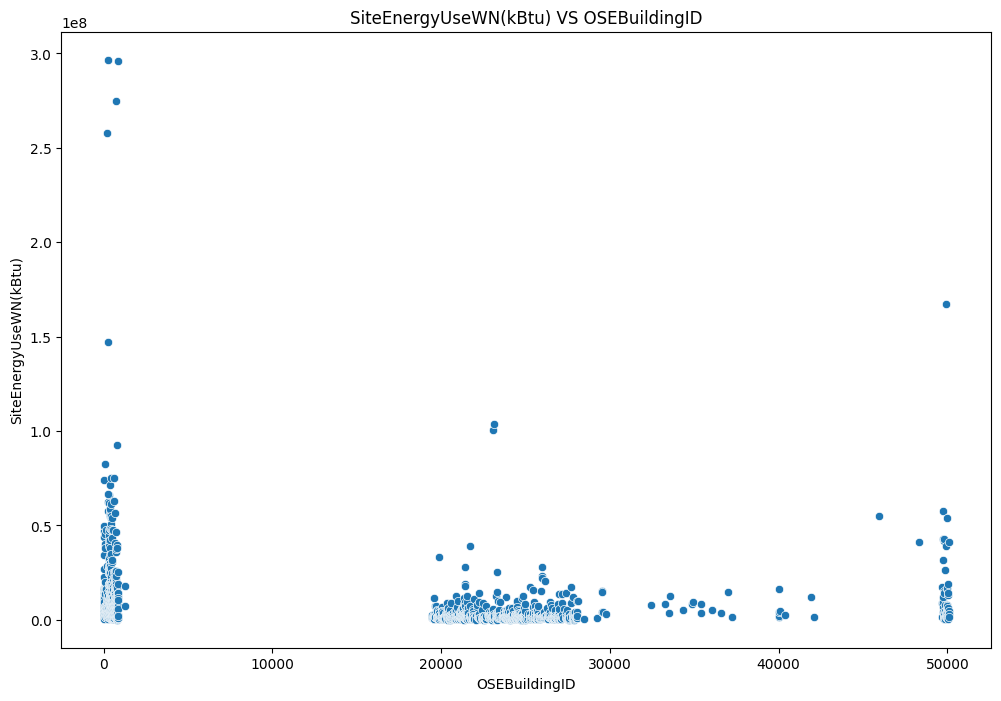

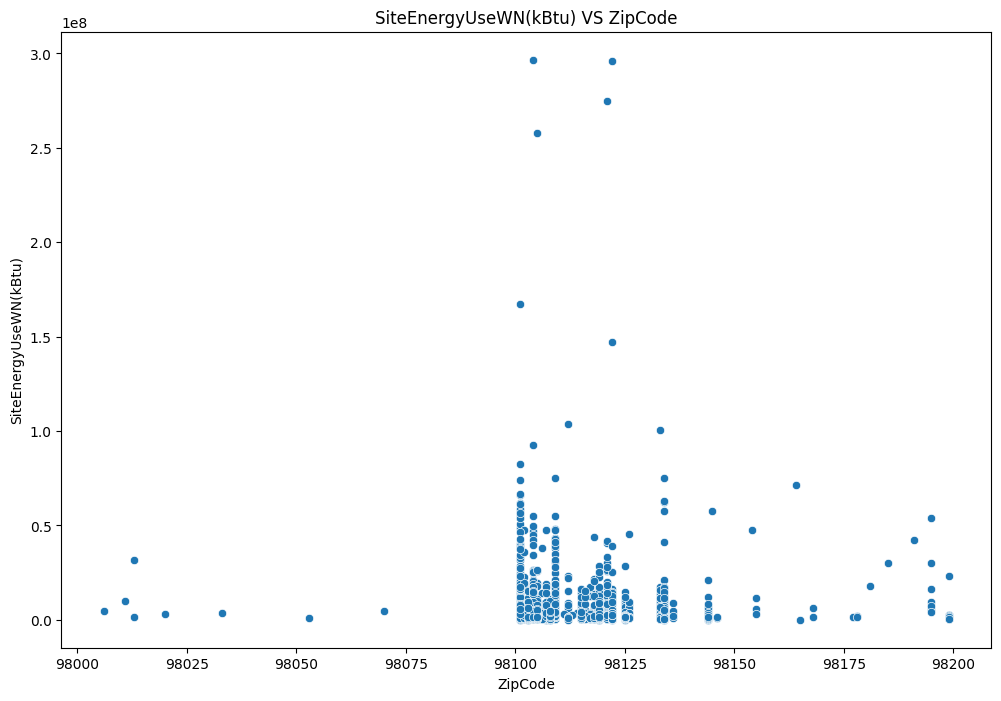

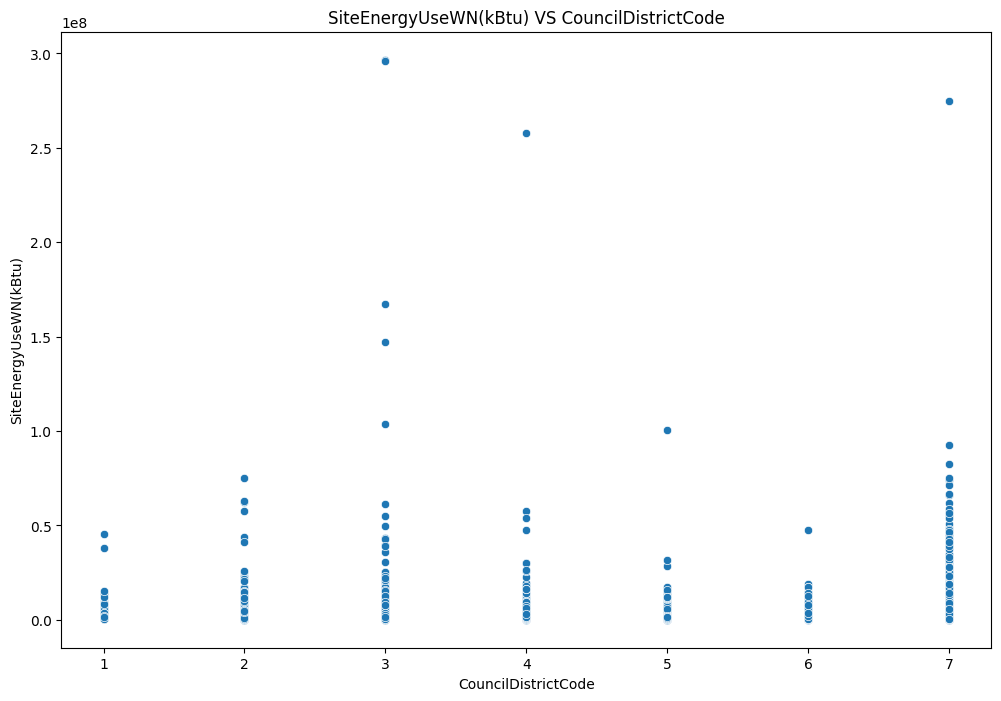

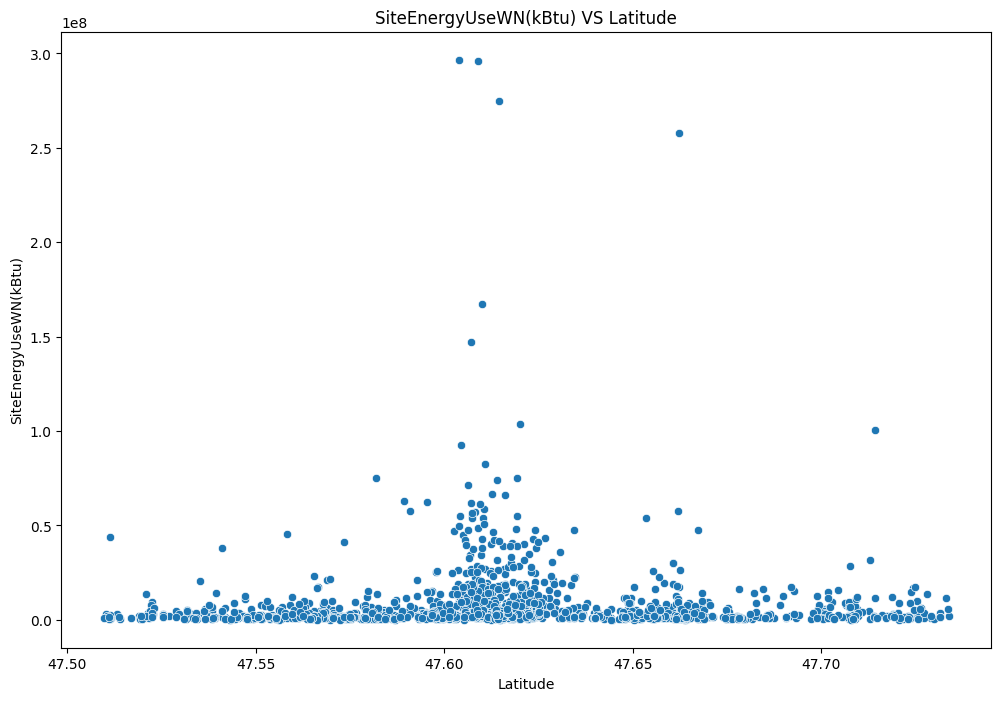

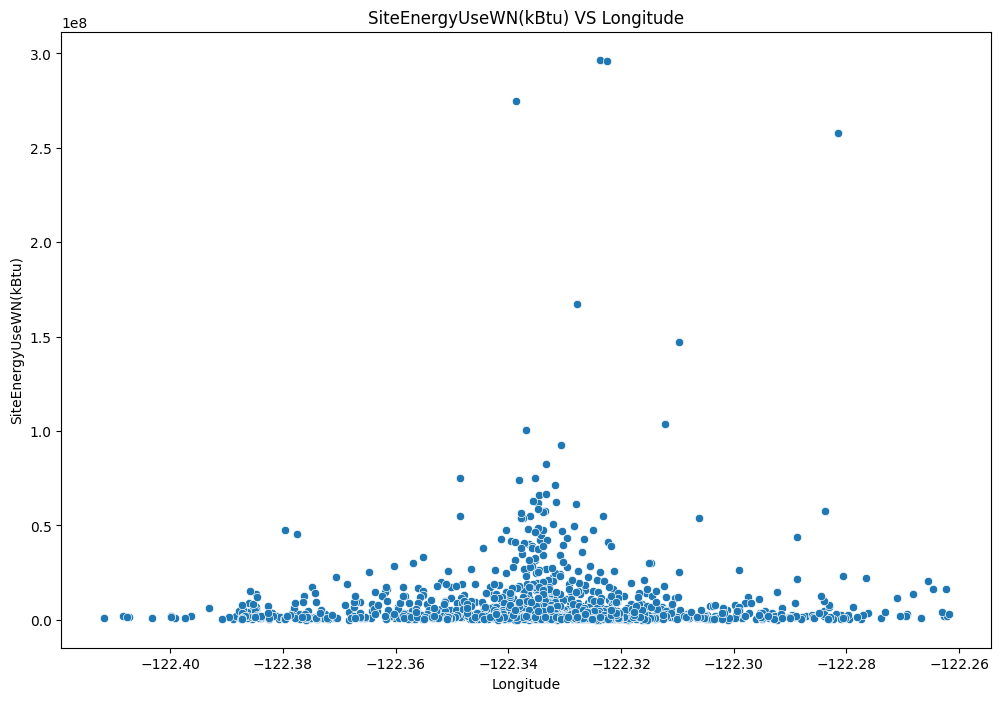

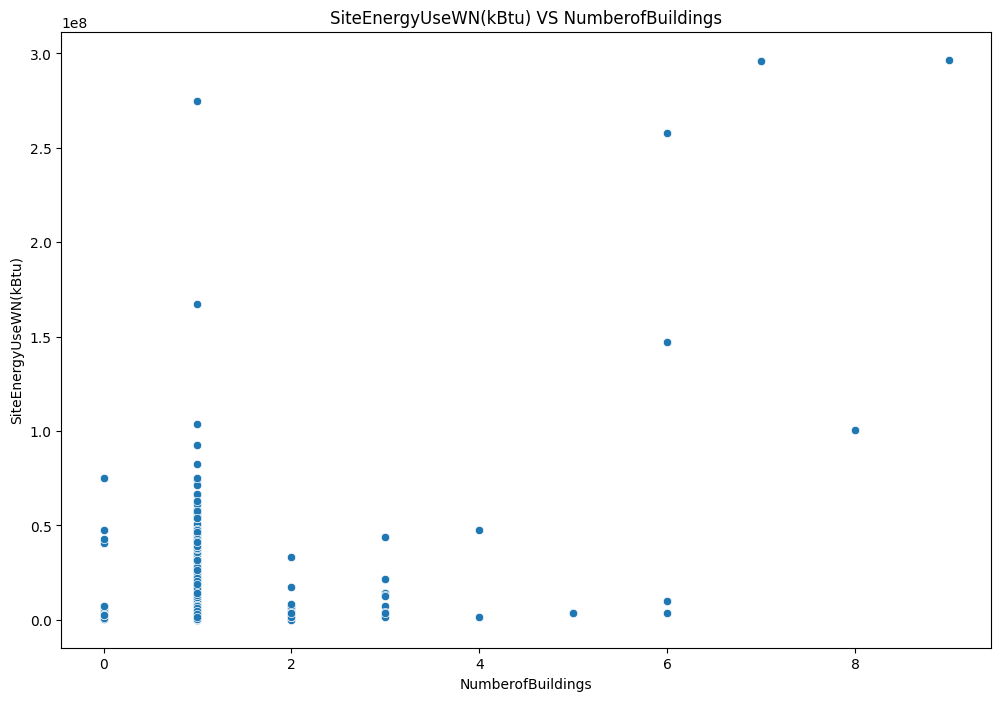

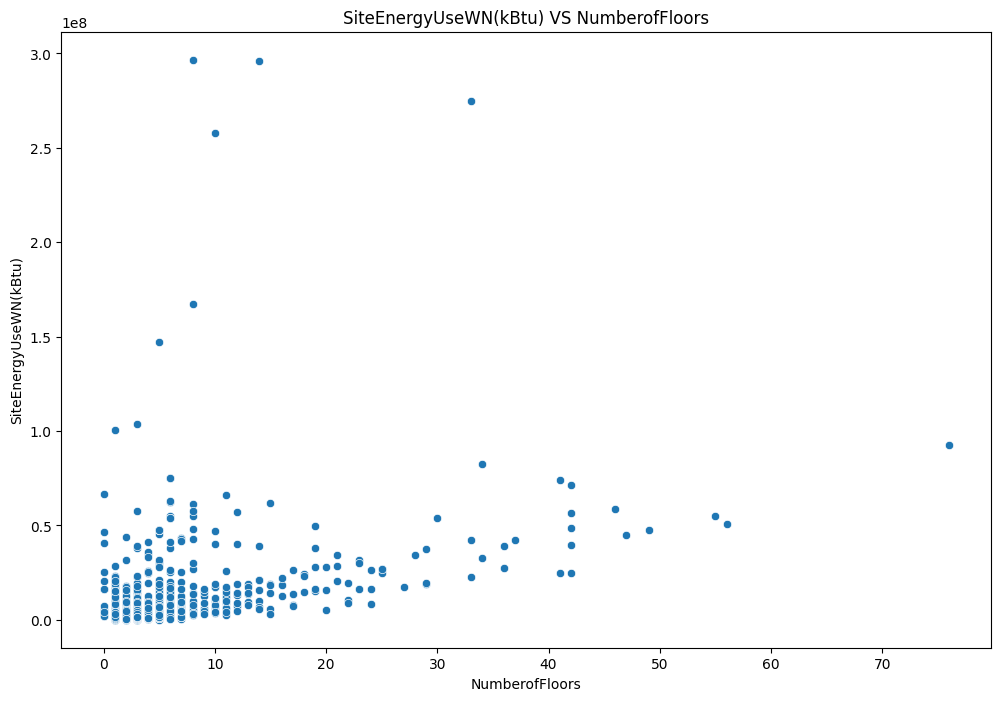

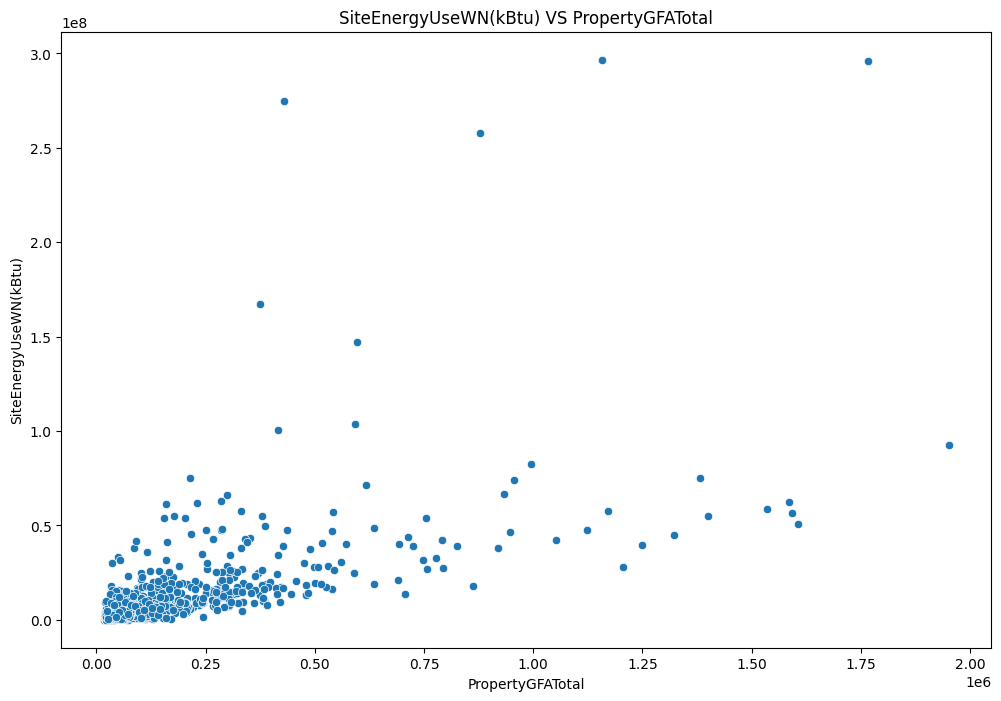

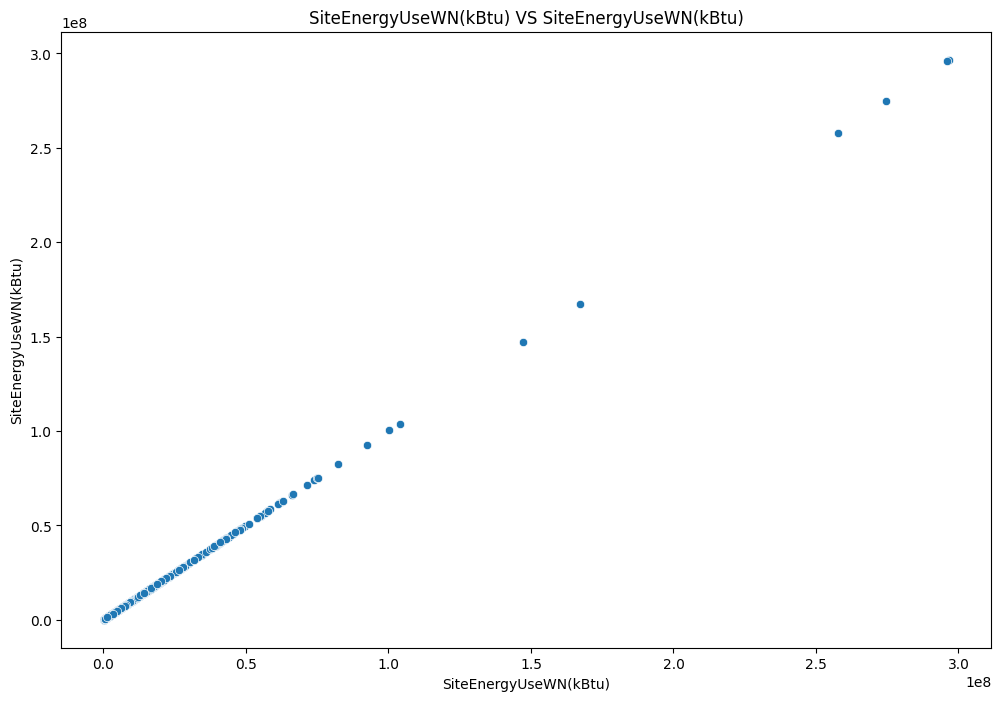

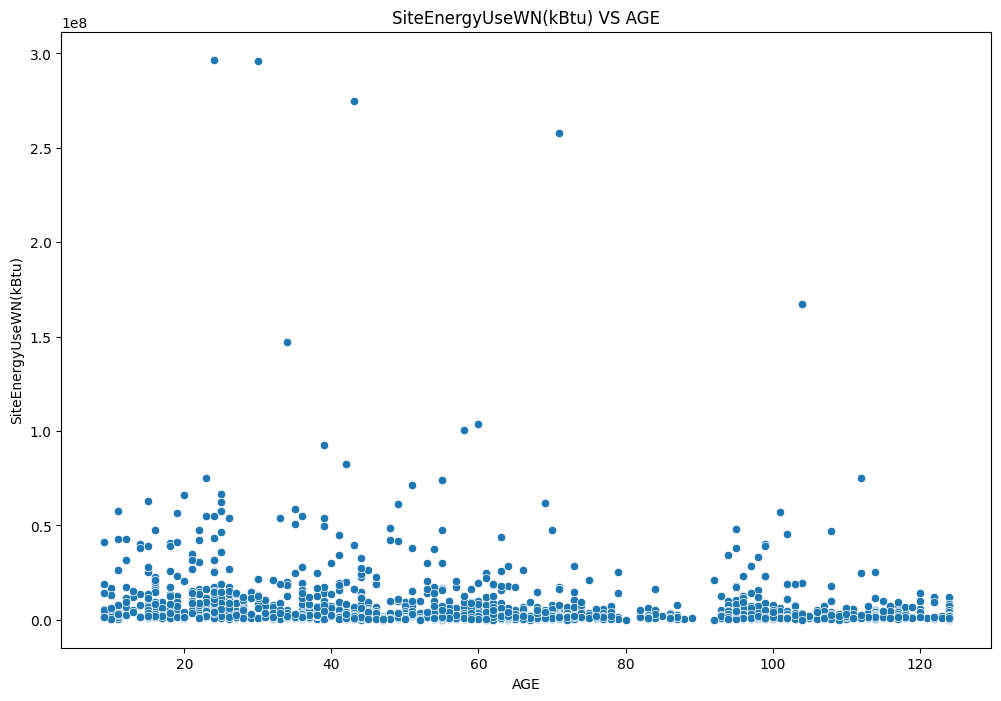

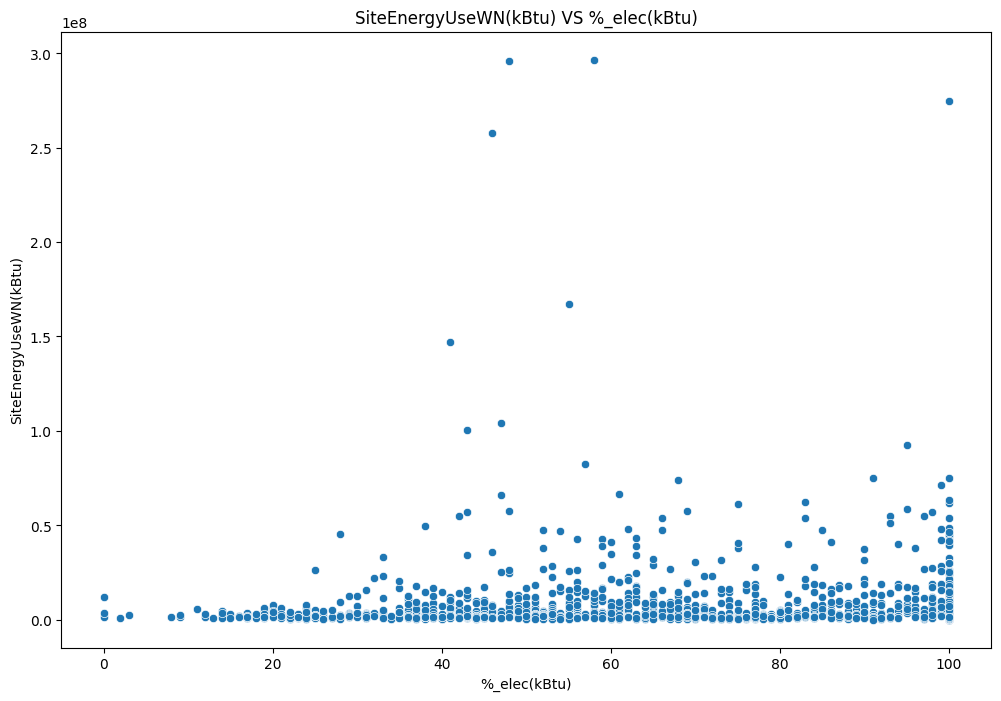

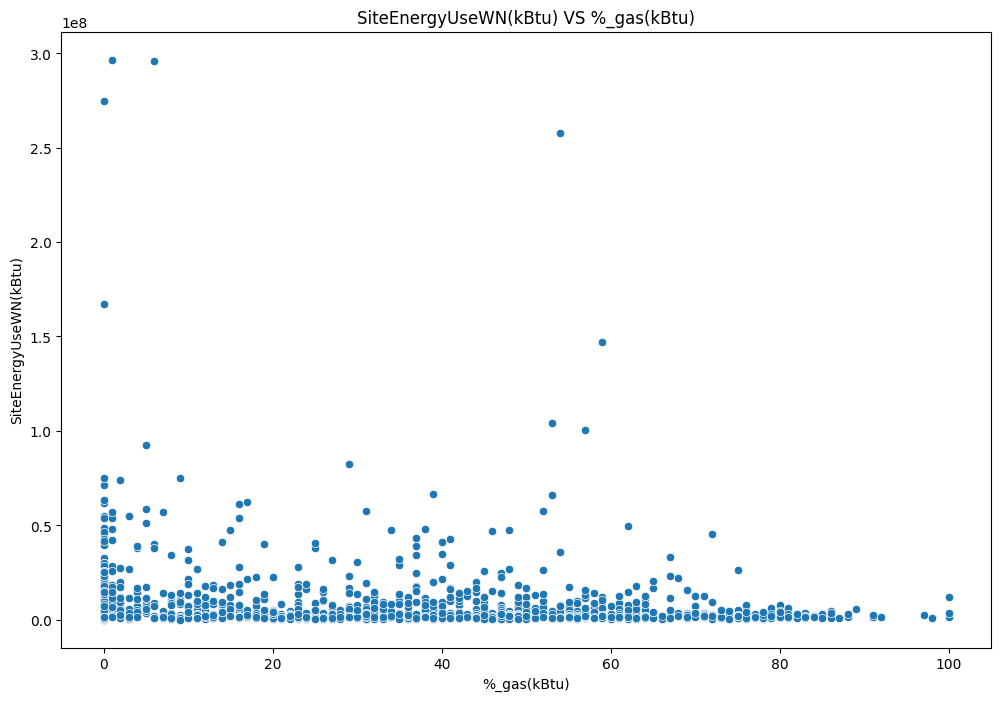

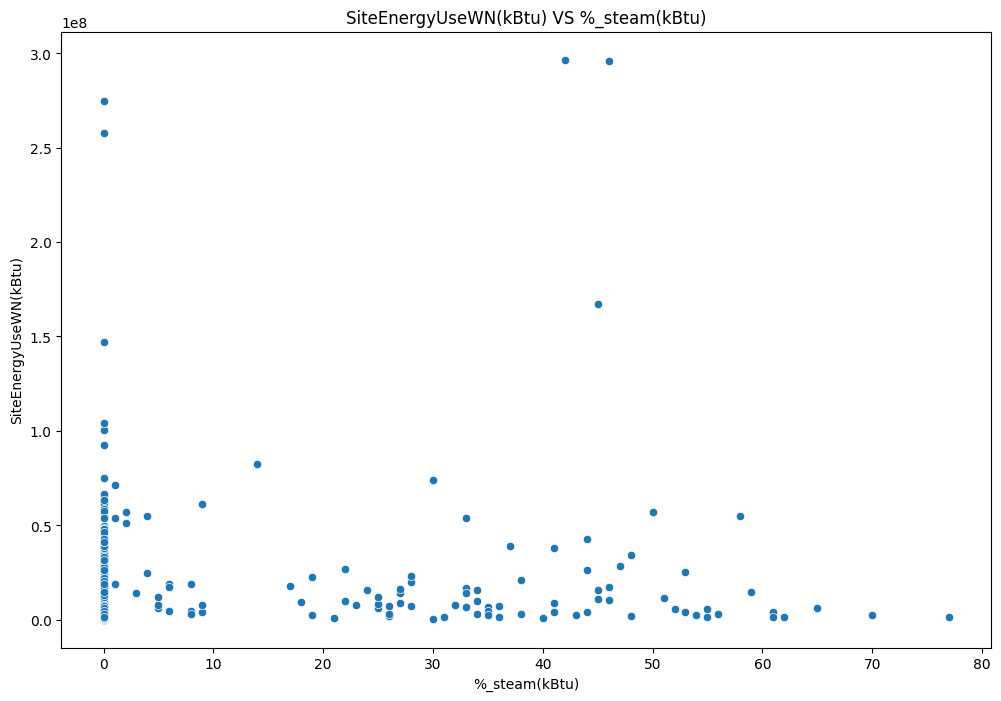

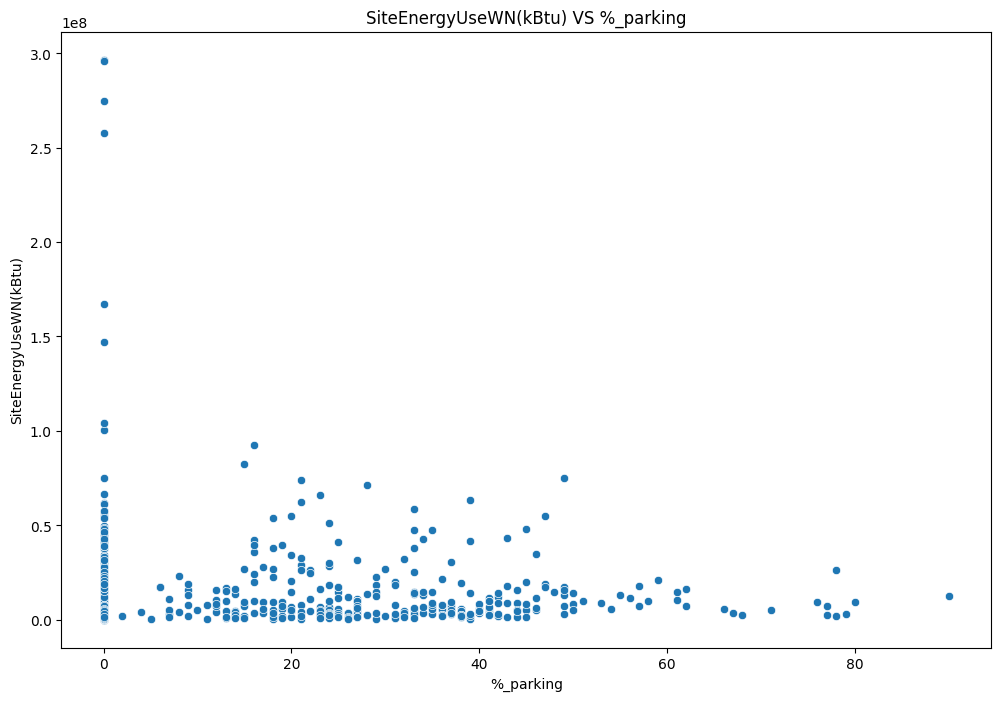

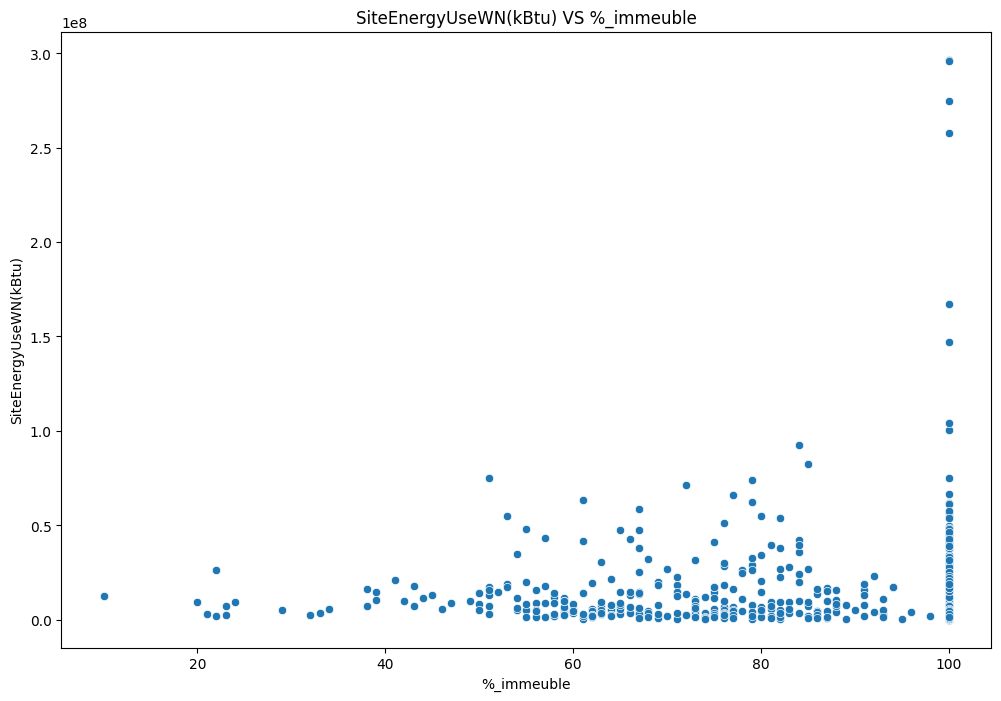

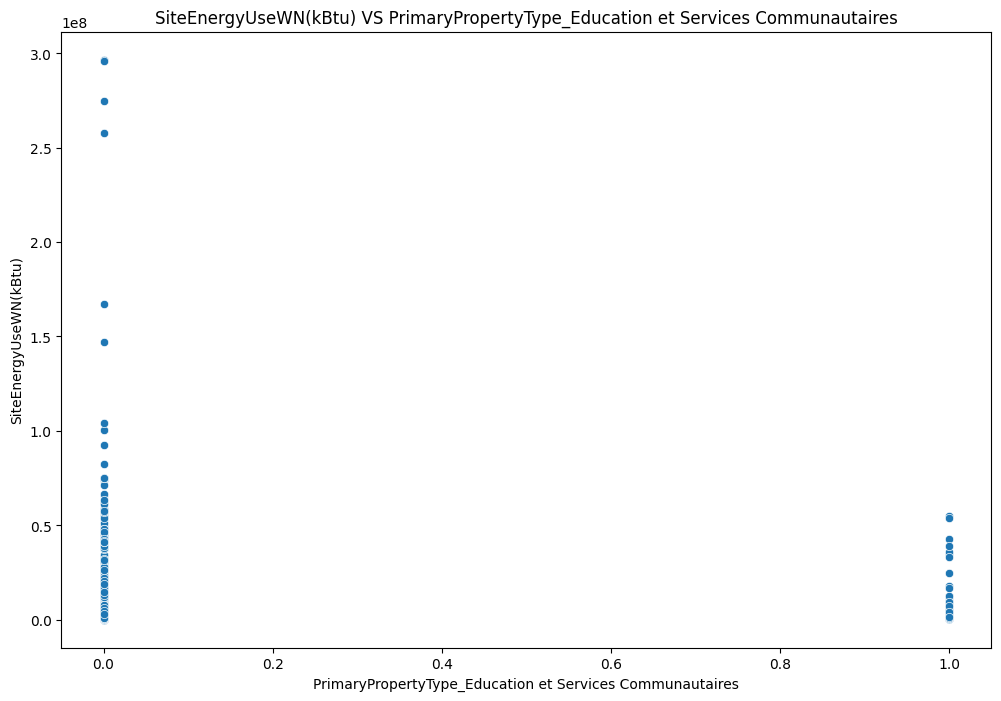

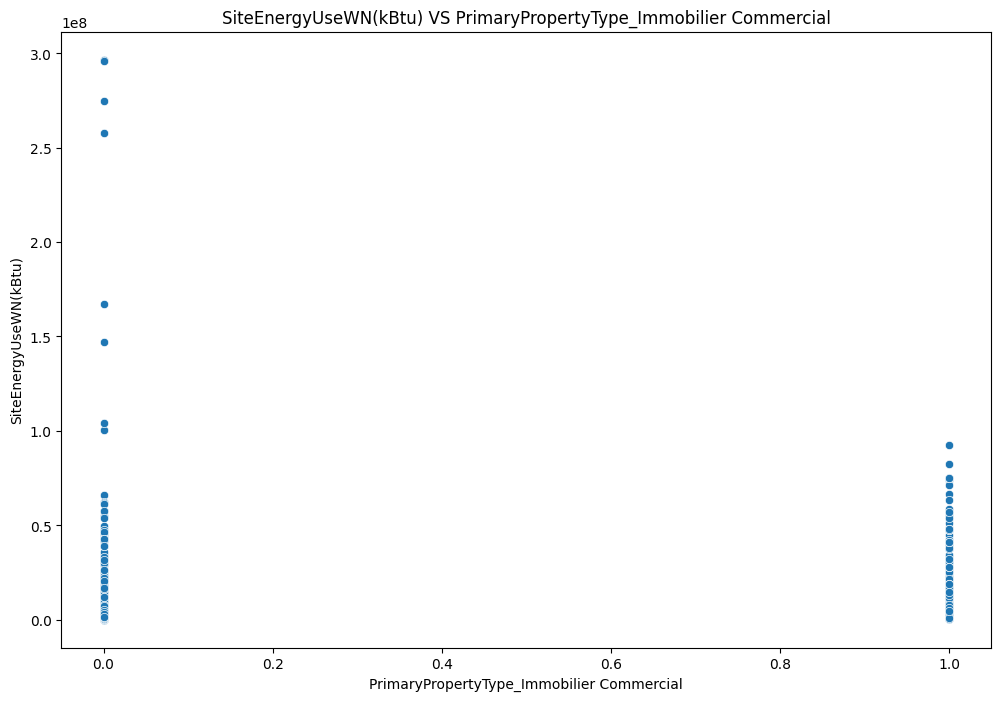

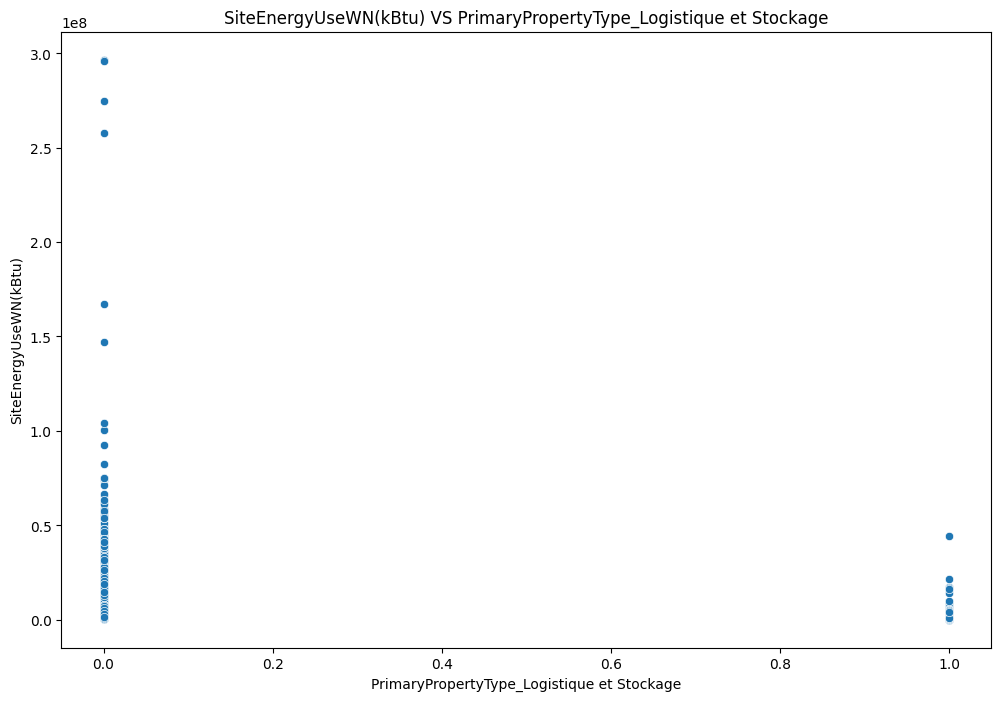

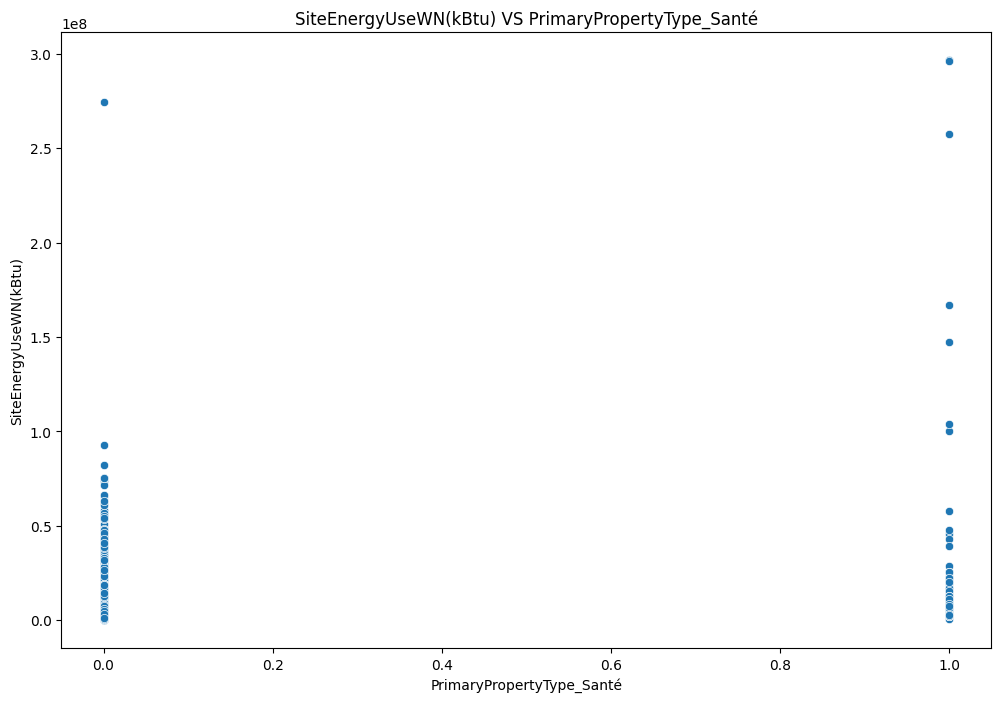

In [702]:
for col in col_num:
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=DF_cleaned_lineaire[col],y=DF_cleaned_lineaire['SiteEnergyUseWN(kBtu)'])
    plt.title(f'SiteEnergyUseWN(kBtu) VS {col}')
    plt.show()

## CREATION ET ENTRAINEMENT DU MODELE

In [703]:

y=DF_cleaned_lineaire['SiteEnergyUseWN(kBtu)']
X=DF_cleaned_lineaire[col_num].drop(['SiteEnergyUseWN(kBtu)'],axis=1)

X=sm.add_constant(X)

In [704]:
model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.585
Model:                               OLS   Adj. R-squared:                  0.580
Method:                    Least Squares   F-statistic:                     117.2
Date:                   Wed, 30 Oct 2024   Prob (F-statistic):          6.22e-255
Time:                           11:32:26   Log-Likelihood:                -25381.
No. Observations:                   1429   AIC:                         5.080e+04
Df Residuals:                       1411   BIC:                         5.089e+04
Df Model:                             17                                         
Covariance Type:               nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

## SELECTION VARIABLES

1. Analyse des corrélations

Corrélations avec SiteEnergyUse:
SiteEnergyUseWN(kBtu)                                       1.000000
PropertyGFATotal                                            0.652583
NumberofBuildings                                           0.465448
NumberofFloors                                              0.418355
PrimaryPropertyType_Santé                                   0.268065
%_steam(kBtu)                                               0.193147
CouncilDistrictCode                                         0.101477
%_parking                                                   0.097619
Longitude                                                   0.036487
Latitude                                                    0.018691
PrimaryPropertyType_Immobilier Commercial                   0.017369
%_elec(kBtu)                                                0.004742
ZipCode                                                    -0.051116
PrimaryPropertyType_Education et Services

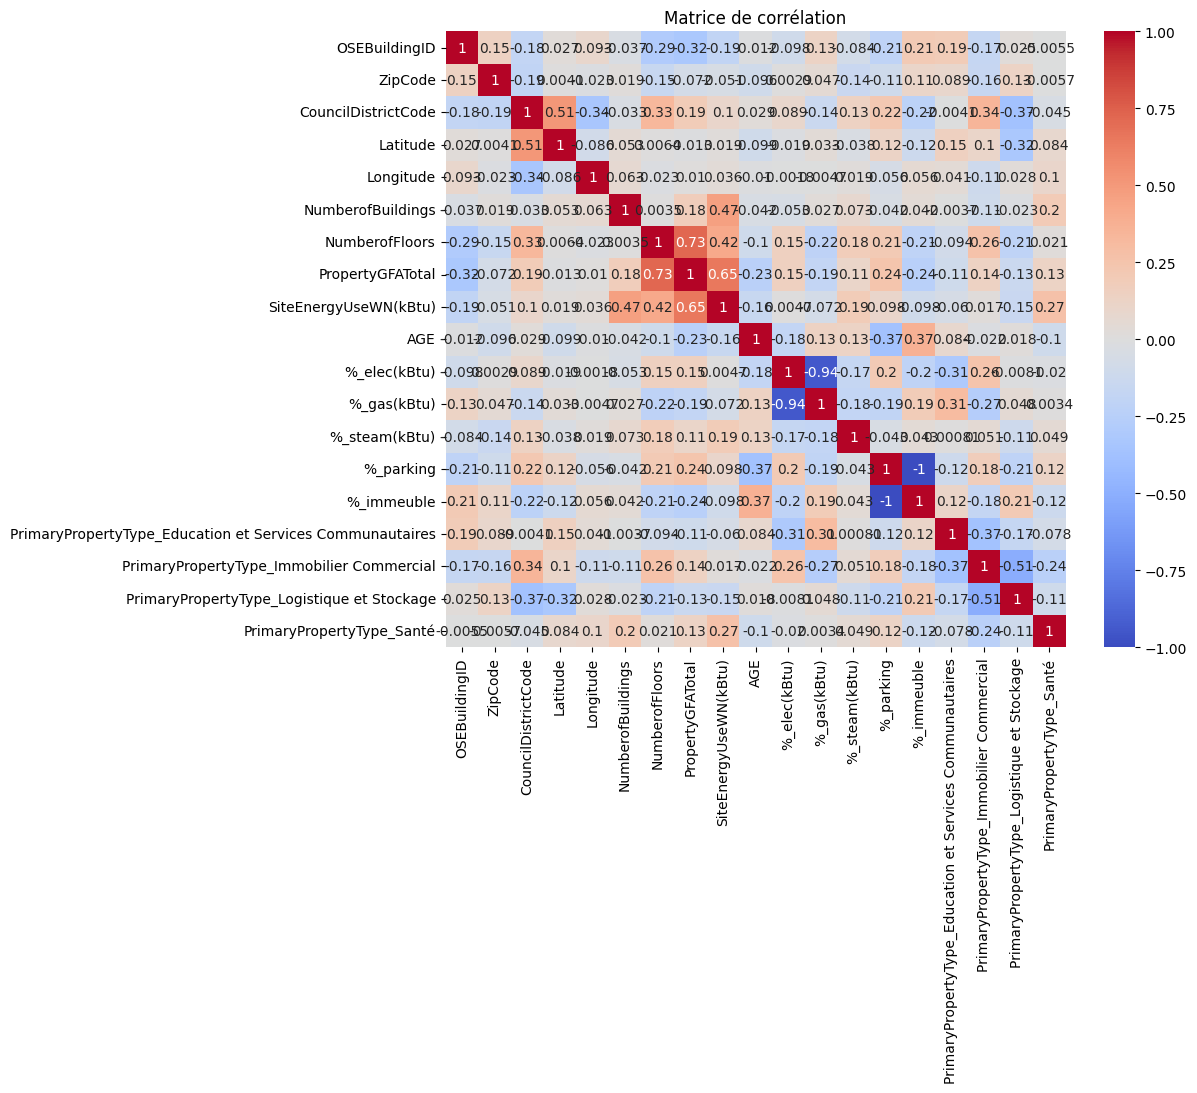

In [705]:

from scipy import stats



data=DF_cleaned_lineaire[col_num]


# 1. Analyse des corrélations
print("1. Analyse des corrélations")
correlations = data[col_num].corr()['SiteEnergyUseWN(kBtu)'].sort_values(ascending=False)
print("\nCorrélations avec SiteEnergyUse:")
print(correlations)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(data[col_num].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()


In [706]:

# 2. Test de significativité individuelle
print("\n2. Tests de significativité individuelle")
X = sm.add_constant(data.drop(['SiteEnergyUseWN(kBtu)'],axis=1))
model = sm.OLS(data['SiteEnergyUseWN(kBtu)'], X).fit()
print("\nRésumé des p-values:")
p_values = pd.DataFrame({
    'Variable': X.columns,
    'P-value': model.pvalues,
    'Significatif': model.pvalues < 0.05
}).sort_values('P-value')
print(p_values)



2. Tests de significativité individuelle

Résumé des p-values:
                                                                                             Variable  \
PropertyGFATotal                                                                     PropertyGFATotal   
NumberofBuildings                                                                   NumberofBuildings   
PrimaryPropertyType_Santé                                                   PrimaryPropertyType_Santé   
PrimaryPropertyType_Logistique et Stockage                 PrimaryPropertyType_Logistique et Stockage   
AGE                                                                                               AGE   
%_steam(kBtu)                                                                           %_steam(kBtu)   
%_gas(kBtu)                                                                               %_gas(kBtu)   
%_elec(kBtu)                                                                             %_elec(

In [707]:

# 3. Analyse VIF (Variance Inflation Factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\n3. Analyse VIF (multicolinéarité)")
vif_data = calculate_vif(X.drop('const', axis=1))
print(vif_data)



3. Analyse VIF (multicolinéarité)
                                             Variable           VIF
13                                         %_immeuble  5.412990e+07
12                                          %_parking  1.582994e+06
10                                        %_gas(kBtu)  5.376792e+04
9                                        %_elec(kBtu)  5.359792e+04
11                                      %_steam(kBtu)  6.638425e+03
15          PrimaryPropertyType_Immobilier Commercial  2.610704e+00
6                                      NumberofFloors  2.553200e+00
7                                    PropertyGFATotal  2.543105e+00
16         PrimaryPropertyType_Logistique et Stockage  2.225312e+00
2                                 CouncilDistrictCode  2.156789e+00
14  PrimaryPropertyType_Education et Services Comm...  1.758386e+00
3                                            Latitude  1.626971e+00
17                          PrimaryPropertyType_Santé  1.376310e+00
8            

In [708]:

# 4. Analyse des R² ajustés avec différentes combinaisons
def evaluate_feature_importance(data):
    results = []
    base_features = []
    remaining_features = list(data.drop('SiteEnergyUseWN(kBtu)', axis=1).columns)
    
    while remaining_features:
        best_score = -np.inf
        best_feature = None
        
        for feature in remaining_features:
            current_features = base_features + [feature]
            X = sm.add_constant(data[current_features])
            model = sm.OLS(data['SiteEnergyUseWN(kBtu)'], X).fit()
            score = model.rsquared_adj
            
            results.append({
                'features': ', '.join(current_features),
                'feature_added': feature,
                'r2_adj': score
            })
            
            if score > best_score:
                best_score = score
                best_feature = feature
        
        if best_feature:
            base_features.append(best_feature)
            remaining_features.remove(best_feature)
            
    return pd.DataFrame(results)

print("\n4. Analyse progressive des caractéristiques")
feature_importance = evaluate_feature_importance(data=data)
print(feature_importance.sort_values('r2_adj', ascending=False).head())



4. Analyse progressive des caractéristiques
                                              features  \
155  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
140  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
131  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
141  PropertyGFATotal, NumberofBuildings, PrimaryPr...   
148  PropertyGFATotal, NumberofBuildings, PrimaryPr...   

                                         feature_added    r2_adj  
155          PrimaryPropertyType_Immobilier Commercial  0.581561  
140                                         %_immeuble  0.581486  
131                                     NumberofFloors  0.581486  
141  PrimaryPropertyType_Education et Services Comm...  0.581430  
148  PrimaryPropertyType_Education et Services Comm...  0.581430  


In [709]:

# 5. Sélection finale des variables
def select_significant_variables(data, threshold_p_value=0.05, threshold_vif=125):
    # Première étape : sélection basée sur p-value
    X = sm.add_constant(data.drop(['SiteEnergyUseWN(kBtu)'],axis=1))
    model = sm.OLS(data['SiteEnergyUseWN(kBtu)'], X).fit()
    significant_vars = X.columns[model.pvalues < threshold_p_value].tolist()
    
    
    # Deuxième étape : vérification VIF
    selected_vars = []
    X_significant = data[significant_vars]
    vif_data = calculate_vif(X_significant)
    
    for var in significant_vars:
        if vif_data[vif_data['Variable'] == var]['VIF'].values[0] < threshold_vif:
            selected_vars.append(var)
    #selected_vars.remove('const')
    return selected_vars

print("\n5. Sélection finale des variables")
selected_vars = select_significant_variables(data)
print("\nVariables sélectionnées:")
print(selected_vars)



5. Sélection finale des variables

Variables sélectionnées:
['NumberofBuildings', 'PropertyGFATotal', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


In [710]:

# Modèle final avec les variables sélectionnées
X_final = sm.add_constant(data[selected_vars])
final_model = sm.OLS(data['SiteEnergyUseWN(kBtu)'], X_final).fit()
print("\nRésumé du modèle final:")
print(final_model.summary())


Résumé du modèle final:
                              OLS Regression Results                             
Dep. Variable:     SiteEnergyUseWN(kBtu)   R-squared:                       0.570
Model:                               OLS   Adj. R-squared:                  0.568
Method:                    Least Squares   F-statistic:                     471.1
Date:                   Wed, 30 Oct 2024   Prob (F-statistic):          8.71e-259
Time:                           11:32:28   Log-Likelihood:                -25407.
No. Observations:                   1429   AIC:                         5.082e+04
Df Residuals:                       1424   BIC:                         5.085e+04
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [711]:
print(selected_vars)

['NumberofBuildings', 'PropertyGFATotal', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


In [712]:


col_num=selected_vars
print(col_num)

['NumberofBuildings', 'PropertyGFATotal', 'PrimaryPropertyType_Logistique et Stockage', 'PrimaryPropertyType_Santé']


### vERIFICATION DES CORRELATIONS

In [713]:
def check_correlations(data, threshold=0.95):
    corr_matrix = data.corr().abs()
    high_corr = np.where(abs(corr_matrix) > threshold)
    pairs = [(data.columns[i], data.columns[j], corr_matrix.iloc[i,j]) 
             for i, j in zip(*high_corr) if i < j]
    if pairs:
        print("Attention : Fortes corrélations détectées")
        for var1, var2, corr in pairs:
            print(f"{var1} - {var2}: {corr:.3f}")
    return pairs

print('Voilà les features qui semblent corrélées entre elles :')
check_correlations(DF_cleaned_lineaire[col_num])

Voilà les features qui semblent corrélées entre elles :


[]

# 1) 'SiteEUIWN(kBtu/sf)'

### DUMMY

In [714]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X=DF_cleaned_lineaire[col_num]
y=DF_cleaned_lineaire['SiteEnergyUseWN(kBtu)']

#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer un Dummy Regressor qui prédit la moyenne
dummy_reg = DummyRegressor(strategy="mean")

# Entraîner le modèle
dummy_reg.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = dummy_reg.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

# Calculer la racine de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculer le coefficient de détermination R²
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


Mean Squared Error: 103167125890943.47
Root Mean Squared Error: 10157121.929510519
R² Score: -0.05520967428754209


### REGRESSION LINEAIRE

In [715]:
from sklearn.linear_model import LinearRegression

# Créer et entraîner un modèle de régression linéaire
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Prédictions
y_pred_linear = linear_reg.predict(X_test)

# Évaluation
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f"Linear Regression MSE: {mse_linear}")
print(f"Linear Regression R² Score: {r2_linear}")



Linear Regression MSE: 45732616574449.8
Linear Regression R² Score: 0.5322395673709612


### REPRESENTATION

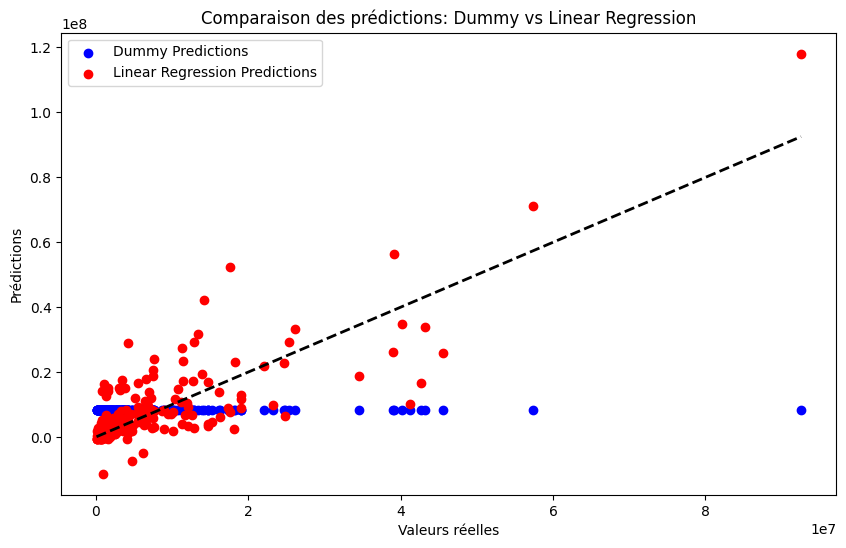

In [716]:


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Dummy Predictions')
plt.scatter(y_test, y_pred_linear, color='red', label='Linear Regression Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Comparaison des prédictions: Dummy vs Linear Regression')
plt.legend()
plt.show()

In [717]:

y_pred=y_pred_linear

seuil = 0.5*DF_cleaned_lineaire['SiteEnergyUseWN(kBtu)'].mean()
# 1. Calculer l'erreur absolue
erreur = np.abs(y_test - y_pred_linear)


In [718]:

# 2. Créer un masque pour les erreurs inférieures au seuil
masque = erreur < seuil


In [719]:

# 3. Obtenir les entrées correspondantes
bonnes_predictions = X_test[masque]
leurs_erreurs = erreur[masque]


In [720]:

# 4. Créer un DataFrame pour une meilleure visualisation
resultats = pd.DataFrame({
    'Vraies_valeurs': y_test[masque],
    'Predictions': y_pred[masque],
    'Erreur(%)': (np.abs(y_test[masque] - y_pred_linear[masque]) / np.abs(y_test[masque])) * 100
})


In [721]:

# 5. Inclure les features originales
resultats = pd.concat([bonnes_predictions, resultats], axis=1)


In [722]:

# 6. Afficher quelques statistiques
print(f"Nombre total de prédictions : {len(y_test)}")
print(f"Nombre de prédictions sous le seuil : {masque.sum()}")
print(f"Pourcentage de bonnes prédictions : {(masque.sum()/len(y_test))*100:.2f}%")
print(seuil*100/DF_cleaned_lineaire['SiteEnergyUseWN(kBtu)'].mean())


Nombre total de prédictions : 286
Nombre de prédictions sous le seuil : 214
Pourcentage de bonnes prédictions : 74.83%
50.0


In [723]:
# 7. Trier par erreur croissante
resultats['Erreur(%)'] = resultats['Erreur(%)'].round(2)
resultats = resultats.sort_values('Erreur(%)')
resultats

,NumberofBuildings,PropertyGFATotal,PrimaryPropertyType_Logistique et Stockage,PrimaryPropertyType_Santé,Vraies_valeurs,Predictions,Erreur(%)
621,1.0,20539,0.0,0.0,1.695248e+06,1.703739e+06,0.50
1205,1.0,153312,0.0,1.0,2.209284e+07,2.197536e+07,0.53
764,1.0,37796,0.0,0.0,2.769792e+06,2.743392e+06,0.95
354,1.0,53002,0.0,0.0,3.591768e+06,3.659481e+06,1.89
1092,1.0,41293,0.0,0.0,3.023468e+06,2.954069e+06,2.30
...,...,...,...,...,...,...,...
792,1.0,22710,0.0,0.0,2.877635e+05,1.834532e+06,537.51
1112,1.0,24617,1.0,0.0,1.094718e+05,-4.990184e+05,555.84
1307,1.0,23232,1.0,0.0,1.273740e+05,-5.824581e+05,557.28
1169,1.0,22200,0.0,0.0,2.318471e+05,1.803807e+06,678.02


In [724]:
resultats.loc[resultats['Erreur(%)']<=10].shape

(31, 7)

In [725]:
resultats['Erreur(%)'].max()

962.01

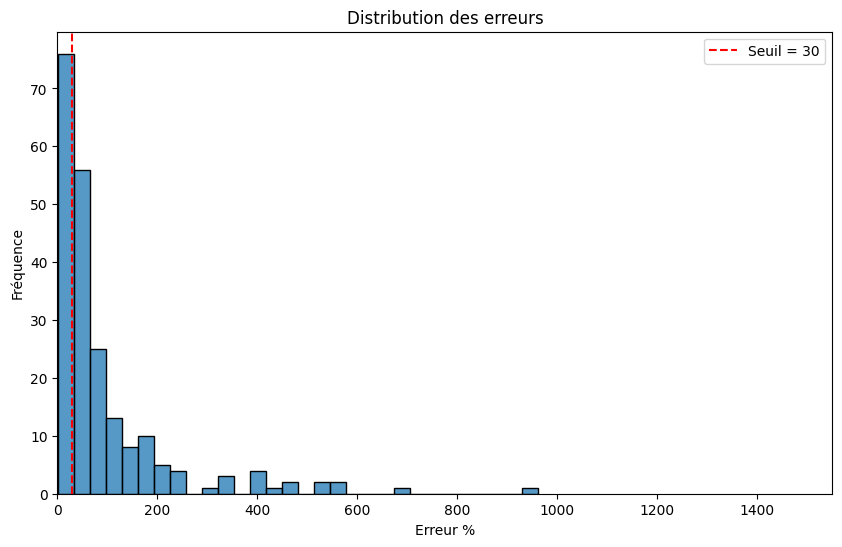

In [726]:
import matplotlib.pyplot as plt
import seaborn as sns
seuil=30
plt.figure(figsize=(10, 6))
sns.histplot(data=resultats['Erreur(%)'], bins=30)
plt.axvline(x=seuil, color='r', linestyle='--', label=f'Seuil = {seuil}')
plt.xlim(0,1550)
plt.title('Distribution des erreurs')
plt.xlabel('Erreur %')
plt.ylabel('Fréquence')
plt.legend()
plt.show()

# ON CONTINUE LA VERIFICATION DES HYPOTHESES DE LA REGRESSION LINEAIRE


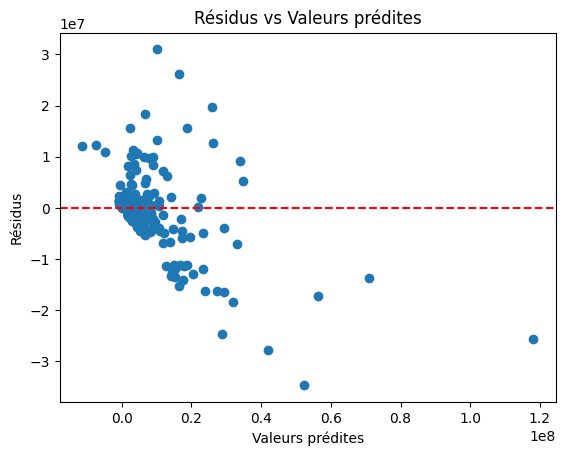

In [727]:
# Plot des résidus vs valeurs prédites
residus = y_test - y_pred_linear
plt.scatter(y_pred_linear, residus)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.title('Résidus vs Valeurs prédites')
plt.show()

## 3) INDEPENDANCE DES RESIDUS (TEST DE DURBIN-WATSON)

In [728]:
from statsmodels.stats.stattools import durbin_watson
dw_test = durbin_watson(residus)
print(f"Durbin-Watson test: {dw_test}")
# Proche de 2 = bon
# <1 ou >3 = problème

Durbin-Watson test: 1.8399420932761286


## 4) HOMOSCEDASTICITE (Variance constante des erreurs) (Test de Breusch-Pagan)

In [729]:
from statsmodels.stats.diagnostic import het_breuschpagan


# Ajouter une constante à X
X_avec_constante = sm.add_constant(X_test)

# Calculer les résidus 
residus = y_test - y_pred_linear

# Effectuer le test de Breusch-Pagan
test_stat, p_value, f_stat, fp_value = het_breuschpagan(residus, X_avec_constante)

print('Statistiques du test de Breusch-Pagan:')
print(f'p-value : {p_value:.4f}')
print(f'statistique de test : {test_stat:.4f}')

# Interprétation
if p_value < 0.05:
    print("Il y a de l'hétéroscédasticité (rejet de H0)")
else:
    print("Pas d'évidence d'hétéroscédasticité (non rejet de H0)")

Statistiques du test de Breusch-Pagan:
p-value : 0.0000
statistique de test : 114.2789
Il y a de l'hétéroscédasticité (rejet de H0)


## 5) NORMALITE DES RESIDUS ( QQ PLOT )

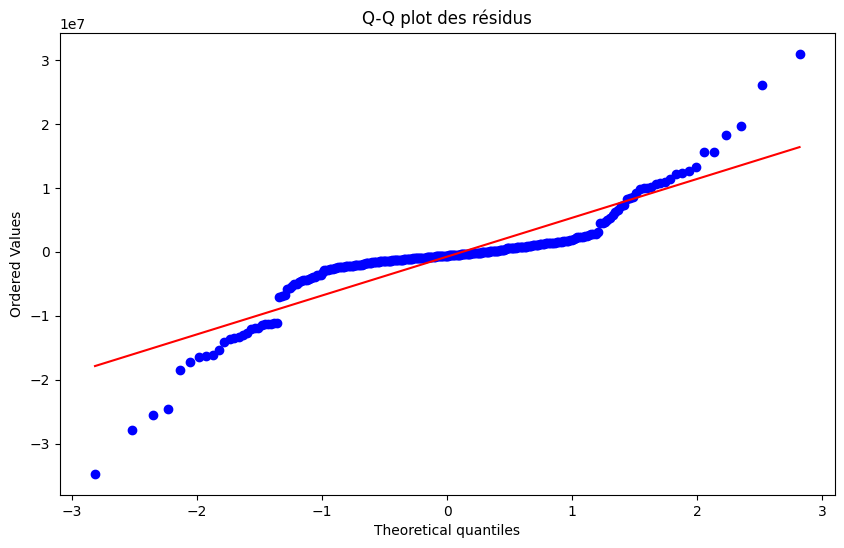

p-value du test Shapiro-Wilk : 7.191837849252285e-18
résidus non normaux


In [730]:
# QQ-plot


plt.figure(figsize=(10,6))
stats.probplot(residus, dist="norm", plot=plt)
plt.title("Q-Q plot des résidus")
plt.show()

# Test de Shapiro-Wilk
_, p_value = stats.shapiro(residus)
print(f"p-value du test Shapiro-Wilk : {p_value}")
if p_value < 0.05 : 
    print('résidus non normaux')
else:
    print('résidus normaux')

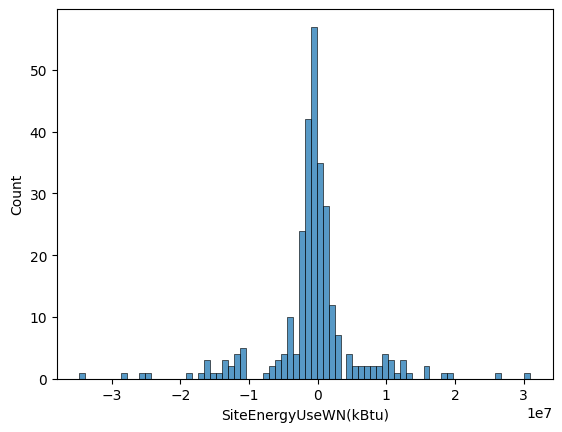

In [731]:
sns.histplot(data=residus)
plt.show()

## 6) ETUDE DES VALEURS ABERRANTES (Distance de COok)

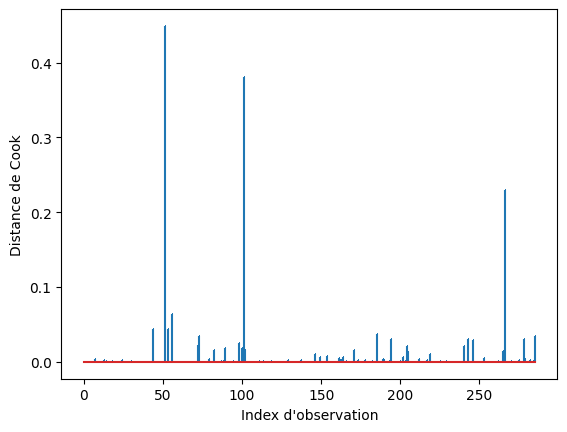

In [732]:
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.api as sm

# Ajuster le modèle avec statsmodels
X_sm = sm.add_constant(X_test)
model_sm = sm.OLS(y_test, X_sm).fit()

# Calculer les distances de Cook
influence = model_sm.get_influence()
cook_distance = influence.cooks_distance[0]

# Plot
plt.stem(range(len(cook_distance)), cook_distance, markerfmt=',')
plt.xlabel("Index d'observation")
plt.ylabel("Distance de Cook")
plt.show()

In [733]:
DF_cleaned_lineaire['SiteEnergyUseWN(kBtu)'].min()

58114.19922

<Axes: xlabel='SiteEnergyUseWN(kBtu)', ylabel='Count'>

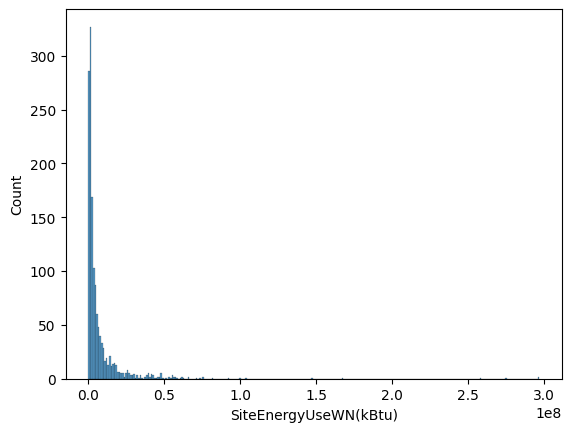

In [734]:
sns.histplot(data=DF_cleaned_lineaire['SiteEnergyUseWN(kBtu)'])